# Imports

In [178]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
plt.style.use('lato_style.mplstyle')

import fidimag.common.constant as C

import os, shutil, glob, re

# Data

Here we load the data from the GNEBM simulations for islands with open boundaries. We load the energy bands from the `ndt` files for different applied fields and hexagon size `R`. We also compute the energy barriers taking the highest energy points in the bands (assuming a single saddle point with higher energy than the rest of the band images)

In [101]:
base_folder = '../simulations/NEBM/nebm_2Dhex_hexagons_PdFe-Ir_sk-down-collapse_B-sweep_DT/'

energy_barriers = {}
energy_bands = {}
distances = {}
energy_bands_interp = {}

R_range = np.array([10, 8, 6, 4, 3])
B_range = np.arange(0, 2001, 100)

for R in R_range:
    
    energy_barriers[R] = {}
    energy_bands[R] = {}
    distances[R] = {}
    energy_bands_interp[R] = {}
    
    for B in B_range:
        
        if R == 10 and B < 800:
            continue
        
        ndt_file = np.loadtxt(base_folder + 'ndts/nebm_2Dhex_hexagon_R{}nm_PdFe-Ir_sk_down-fm_up_B{}mT_CI-GNEBM_energy.ndt'.format(R, B))
        last_energy_band = ndt_file[-1][1:]
        last_energy_band = (last_energy_band - last_energy_band[0]) / C.meV
        
        dYs_file = np.loadtxt(base_folder + 'ndts/nebm_2Dhex_hexagon_R{}nm_PdFe-Ir_sk_down-fm_up_B{}mT_CI-GNEBM_dYs.ndt'.format(R, B))
        dYs_file = np.append([0], dYs_file[-1][1:])
        
        dat_file = np.loadtxt(base_folder + 'dats/nebm_2Dhex_hexagon_R{}nm_PdFe-Ir_sk_down-fm_up_B{}mT_CI-GNEBM_interpolation.dat'.format(R, B))
        dat_file[:, 1] = (dat_file[:, 1] - dat_file[:, 1][0]) / C.meV
        
        energy_bands[R][B] = last_energy_band
        energy_barriers[R][B] = np.max(last_energy_band)
        distances[R][B] = np.cumsum(dYs_file)
        energy_bands_interp[R][B] = dat_file - dat_file[0]

Save the energy barriers as a function of `B` into single arrays (named `energy_barriers_map`) for different `R`:

In [108]:
B_range = np.arange(0, 2001, 100)

energy_barriers_map = {}

for i, R in enumerate(R_range):
    energy_barriers_map[R] = np.zeros((len(B_range)))
    for j, B in enumerate(B_range):
        if R == 10 and B < 800:
            continue
        energy_barriers_map[R][j] = energy_barriers[R][B]

Plot the energy barriers as a function of applied field for different hexagon sizes:

(0, 160)

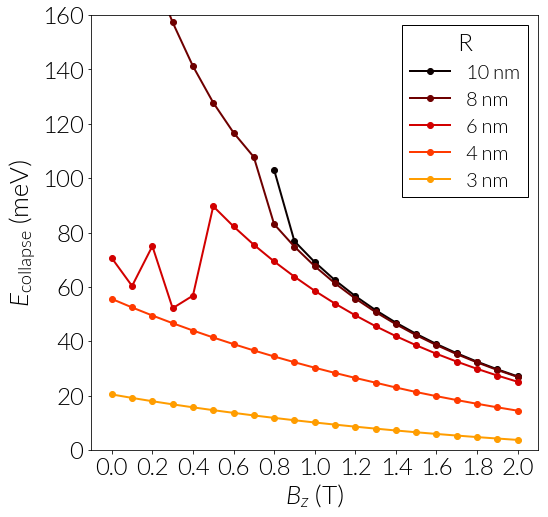

In [109]:
# B_range = np.arange(0, 2001, 100)

cm_subsection = np.linspace(0.4, 1, len(R_range)) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection][-1::-1]

f = plt.figure()
ax = f.add_subplot(111)

for i, R in enumerate(R_range):
    
    if R == 10:
        fields_range = slice(8, None)
    else:
        fields_range = slice(0, None)
        
    ax.plot(B_range[fields_range] * 1e-3, energy_barriers_map[R][fields_range], 'o-', 
            color=cm_colors[i], label='{} nm'.format(R))

ax.set_xticks(B_range[::2] * 1e-3)
ax.set_xticklabels(B_range[::2] * 1e-3)
    
ax.legend(title='R', 
          # loc=(0.05, 0.36),
          loc=1)

ax.set_ylabel(r'$E_{\mathrm{collapse}}$ (meV)')
ax.set_xlabel(r'$B_{z}$ (T)')

ax.set_ylim(0, 160)

# plt.savefig('hexagons_nebm_R_B_skyrmion-collapse-energy-barrier.pdf',
#             bbox_inches='tight')

We can also plot the whole energy bands for different field and hexagon size:

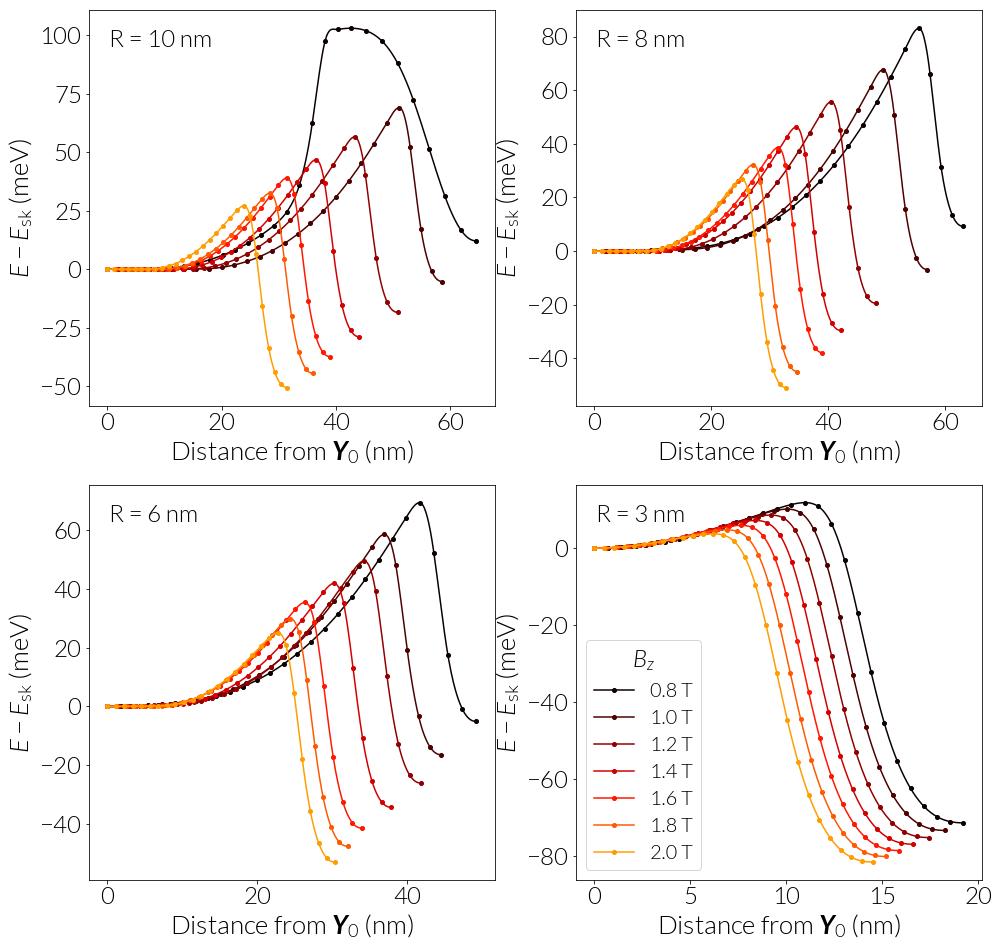

In [27]:
B_range = np.arange(800, 2001, 100)

cm_subsection = np.linspace(0.4, 1, len(B_range[::2])) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection][-1::-1]

f = plt.figure(figsize=(16, 16))

for j, R in enumerate([10, 8, 6, 3]):
    ax = f.add_subplot(2, 2, j + 1)

    ps = []

    for i, B in enumerate(B_range[::2]):
        p, = ax.plot(distances[R][B], energy_bands[R][B], 'o', color=cm_colors[i],
                label='{:.1f} T'.format(B * 1e-3),
                ms=4
                )
        ps.append(p)

        p, = ax.plot(energy_bands_interp[R][B][:, 0], energy_bands_interp[R][B][:, 1],
                '-', color=cm_colors[i],
                # label='{:.1f} T'.format(B * 1e-3)
                )
        ps.append(p)
        
    ax.set_xlabel(r'Distance from $\mathbf{Y}_{0}$ (nm)')
    ax.set_ylabel(r'$E-E_{\mathrm{sk}}$ (meV)')

    ax.text(0.05, 0.95, 'R = {} nm'.format(R), horizontalalignment='left',
            verticalalignment='top', transform=ax.transAxes, 
            fontsize=24, rotation=0)

    if j == 3:
        ax.legend(zip(ps[::2], ps[1::2]), [pl.get_label() for pl in ps[::2]],
                  title=r'$B_{z}$')
        
# plt.savefig('hexagons_nebm_R_B_skyrmion-escape-energy-bands.pdf',
#             bbox_inches='tight')

Energy bands for weak fields, $B_{z}\leq0.8\,\,\text{T}$

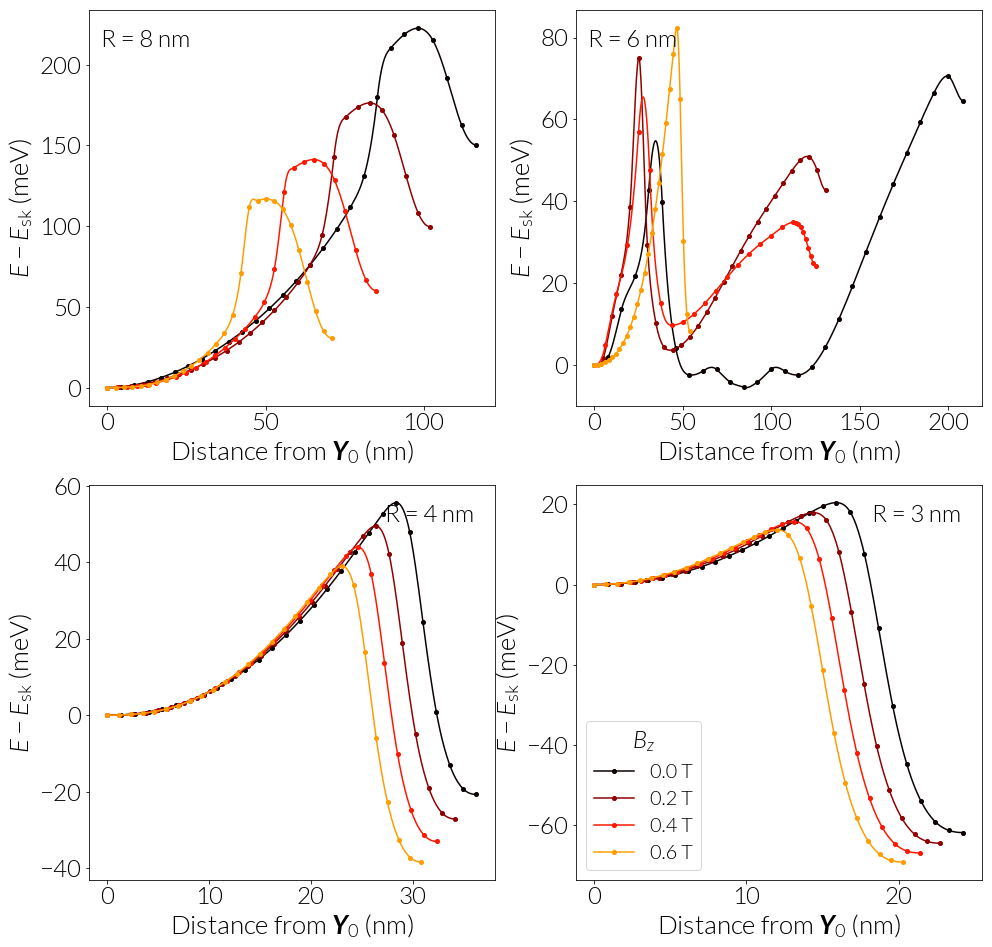

In [28]:
B_range = np.arange(0, 2001, 100)
B_range_plot = list(B_range[:7:2])

cm_subsection = np.linspace(0.4, 1, len(B_range_plot)) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection][-1::-1]

f = plt.figure(figsize=(16, 16))

for j, R in enumerate([8, 6, 4, 3]):
    ax = f.add_subplot(2, 2, j + 1)

    ps = []

    for i, B in enumerate(B_range_plot):
        
        if R == 10 and B < 800:
            continue
        
        p, = ax.plot(distances[R][B], energy_bands[R][B], 'o', color=cm_colors[i],
                label='{:.1f} T'.format(B * 1e-3),
                ms=4
                )
        ps.append(p)

        p, = ax.plot(energy_bands_interp[R][B][:, 0], energy_bands_interp[R][B][:, 1],
                '-', color=cm_colors[i],
                # label='{:.1f} T'.format(B * 1e-3)
                )
        ps.append(p)
        
    ax.set_xlabel(r'Distance from $\mathbf{Y}_{0}$ (nm)')
    ax.set_ylabel(r'$E-E_{\mathrm{sk}}$ (meV)')

    if j > 1:
        tpos = (0.95, 0.95)
    else:
        tpos = (0.25, 0.95)

    ax.text(tpos[0], tpos[1], 'R = {} nm'.format(R), horizontalalignment='right',
            verticalalignment='top', transform=ax.transAxes, 
            fontsize=24, rotation=0)

    if j == 3:
        ax.legend(zip(ps[::2], ps[1::2]), [pl.get_label() for pl in ps[::2]],
                  title=r'$B_{z}$', loc=3)
        
# plt.savefig('hexagons_nebm_R_B_skyrmion-escape-energy-bands.pdf',
#             bbox_inches='tight')

We can try to observe these transitions using the `npt` library:

In [36]:
import nebm_plot_tools.nebm_plot_tools as npt
from IPython.display import Image

In [157]:
def last_GNEBM_state(R, B):
    base_folder = '../simulations/NEBM/nebm_2Dhex_hexagons_PdFe-Ir_sk-down-collapse_B-sweep_DT/'
    _folder = base_folder + 'vtks/nebm_2Dhex_hexagon_R{}nm_PdFe-Ir_sk_down-fm_up_B{}mT_CI-GNEBM'.format(R, B)
    _folder = sorted(glob.glob(_folder + '*'),
                     key=lambda f: int(re.search('(?<=GNEBM_)\d+', f).group(0)))[-1]
    return os.path.basename(_folder)

In [196]:
for B in [400, 800]:
    npt.plot_mayavi2(last_GNEBM_state(6, B), 
                     [0, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 27],
                     cmap='YlOrRd',
                     # reversed_map=True,
                     gridn='4x3', 
                     rel_folder=base_folder,
                     savef='grid.png', 
                     text_fontsize=120, 
                     camera_distance=20,
                     zoom=3,
                     annotate_numbers=False
                     )

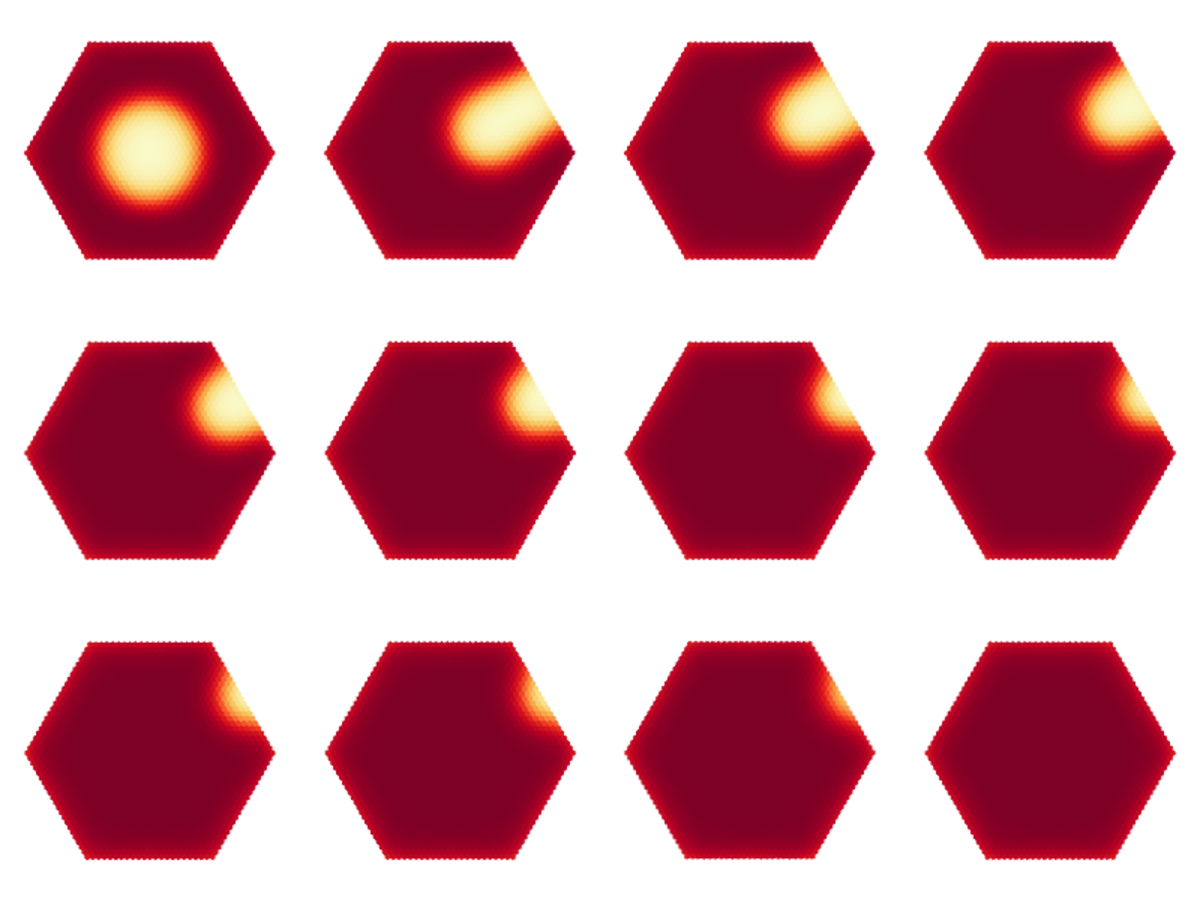

In [184]:
Image(os.path.join('png', last_GNEBM_state(6, 400), 'grid.png'), width=500)

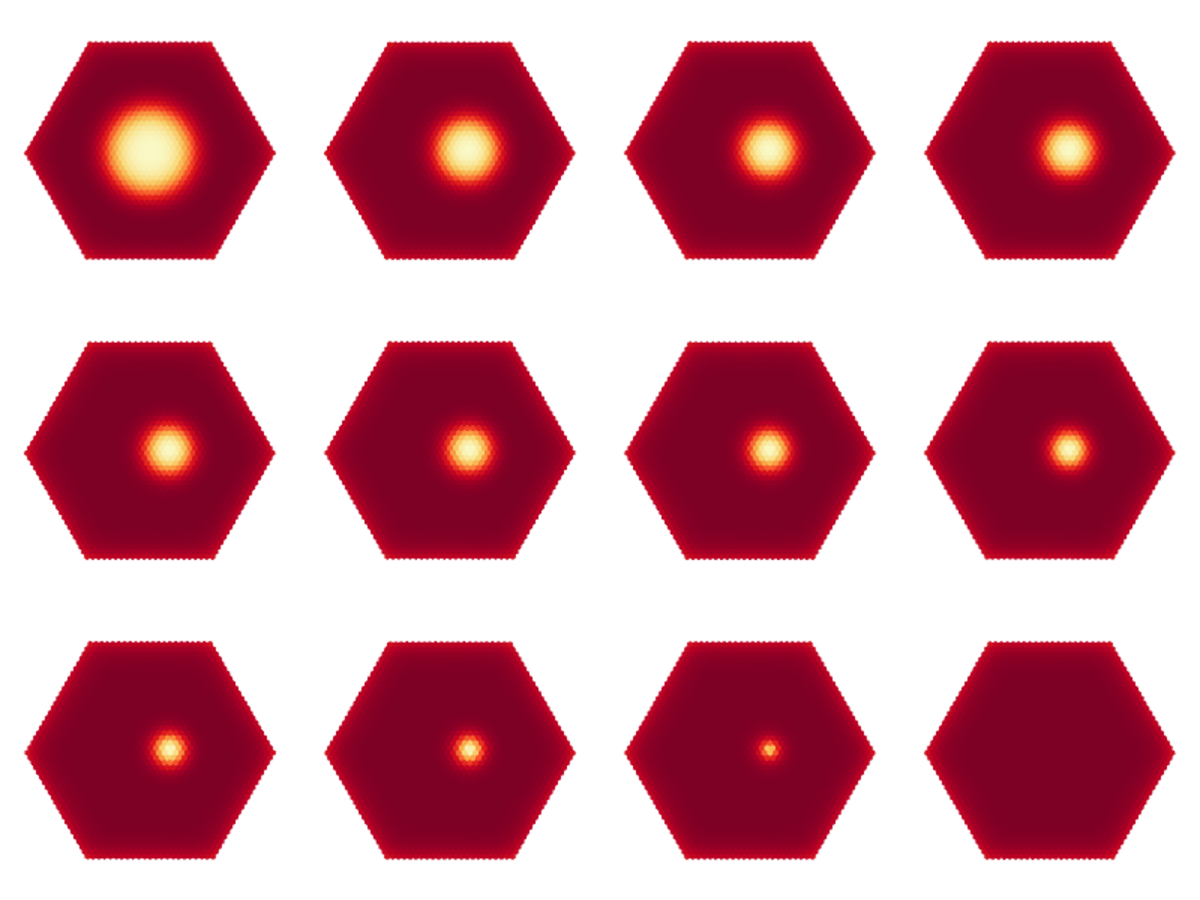

In [185]:
Image(os.path.join('png', last_GNEBM_state(6, 800), 'grid.png'), width=500)

# Ferromagnetic boundaries

Here we perform the same analysis but using the simulations of hexagons with a ferromagnetic rim:

In [146]:
base_folder = '../simulations/NEBM/nebm_2Dhex_hexagons_PdFe-Ir_sk-down-collapse_B-sweep_pinned_boundary_DT/'

energy_barriers_pinbs = {}
energy_bands_pinbs = {}
distances_pinbs = {}
energy_bands_interp_pinbs = {}

R_range = np.array([10, 8, 6, 4, 3])
B_range = np.arange(0, 2001, 100)

for R in R_range:
    
    energy_barriers_pinbs[R] = {}
    energy_bands_pinbs[R] = {}
    distances_pinbs[R] = {}
    energy_bands_interp_pinbs[R] = {}
    
    for B in B_range:
        
        if R == 10 and B < 600:
            continue
        
        ndt_file = np.loadtxt(base_folder + 'ndts/nebm_2Dhex_hexagon_R{}nm_PdFe-Ir_sk_down-fm_up_B{}mT_CI-GNEBM_energy.ndt'.format(R, B))
        last_energy_band = ndt_file[-1][1:]
        last_energy_band = (last_energy_band - last_energy_band[0]) / C.meV
        
        dYs_file = np.loadtxt(base_folder + 'ndts/nebm_2Dhex_hexagon_R{}nm_PdFe-Ir_sk_down-fm_up_B{}mT_CI-GNEBM_dYs.ndt'.format(R, B))
        dYs_file = np.append([0], dYs_file[-1][1:])
        
        dat_file = np.loadtxt(base_folder + 'dats/nebm_2Dhex_hexagon_R{}nm_PdFe-Ir_sk_down-fm_up_B{}mT_CI-GNEBM_interpolation.dat'.format(R, B))
        dat_file[:, 1] = (dat_file[:, 1] - dat_file[:, 1][0]) / C.meV
        
        energy_bands_pinbs[R][B] = last_energy_band
        energy_barriers_pinbs[R][B] = np.max(last_energy_band)
        distances_pinbs[R][B] = np.cumsum(dYs_file)
        energy_bands_interp_pinbs[R][B] = dat_file - dat_file[0]

In [147]:
B_range = np.arange(0, 2001, 100)
energy_barriers_map_pinbs = {}

for i, R in enumerate(R_range):
    energy_barriers_map_pinbs[R] = np.zeros(len(B_range))
    for j, B in enumerate(B_range):
        if R == 10 and B < 600:
            continue
        energy_barriers_map_pinbs[R][j] = energy_barriers_pinbs[R][B]

Text(0.5,0,'$B_{z}$ (T)')

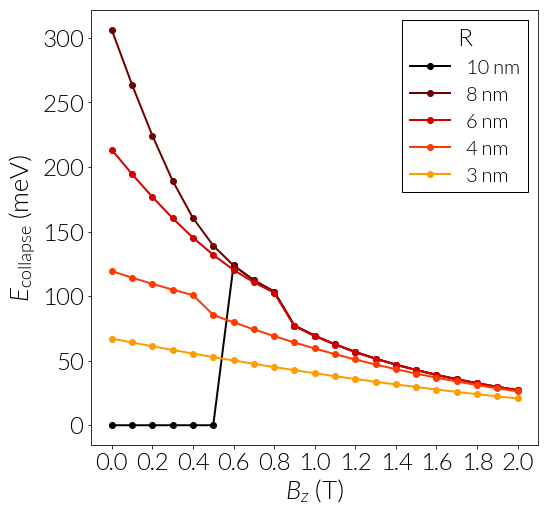

In [140]:
cm_subsection = np.linspace(0.4, 1, len(R_range)) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection][-1::-1]

f = plt.figure()
ax = f.add_subplot(111)

for i, R in enumerate(R_range):
         
    ax.plot(B_range[fields_range] * 1e-3, energy_barriers_map_pinbs[R][fields_range], 'o-', 
            color=cm_colors[i], label='{} nm'.format(R))
    
ax.set_xticks(B_range[::2] * 1e-3)
ax.set_xticklabels(B_range[::2] * 1e-3)
    
ax.legend(title='R', 
          # loc=(0.05, 0.36),
          loc=1)

ax.set_ylabel(r'$E_{\mathrm{collapse}}$ (meV)')
ax.set_xlabel(r'$B_{z}$ (T)')

# ax.set_ylim(0, 160)

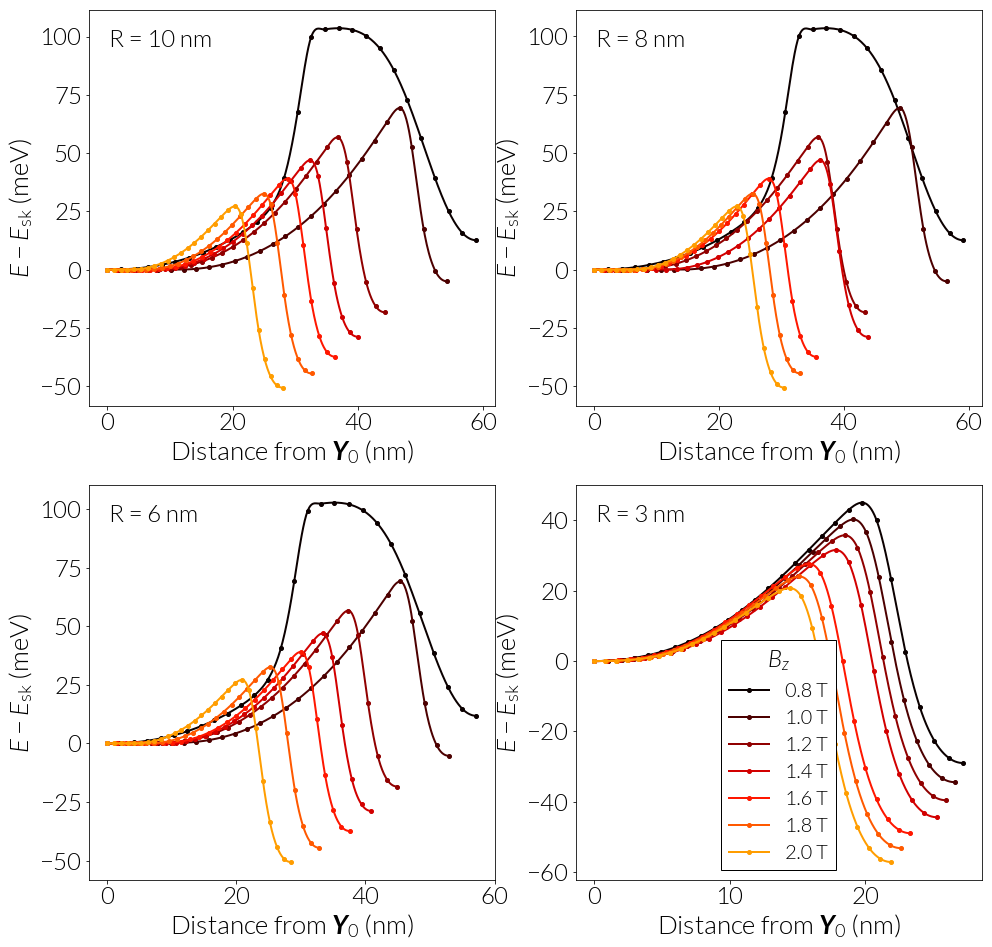

In [148]:
B_range = np.arange(800, 2001, 100)

cm_subsection = np.linspace(0.4, 1, len(B_range[::2])) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection][-1::-1]

f = plt.figure(figsize=(16, 16))

for j, R in enumerate([10, 8, 6, 3]):
    ax = f.add_subplot(2, 2, j + 1)

    ps = []

    for i, B in enumerate(B_range[::2]):
        p, = ax.plot(distances_pinbs[R][B], energy_bands_pinbs[R][B], 'o', color=cm_colors[i],
                label='{:.1f} T'.format(B * 1e-3),
                ms=4
                )
        ps.append(p)

        p, = ax.plot(energy_bands_interp_pinbs[R][B][:, 0], energy_bands_interp_pinbs[R][B][:, 1],
                '-', color=cm_colors[i],
                # label='{:.1f} T'.format(B * 1e-3)
                )
        ps.append(p)
        
    ax.set_xlabel(r'Distance from $\mathbf{Y}_{0}$ (nm)')
    ax.set_ylabel(r'$E-E_{\mathrm{sk}}$ (meV)')

    ax.text(0.05, 0.95, 'R = {} nm'.format(R), horizontalalignment='left',
            verticalalignment='top', transform=ax.transAxes, 
            fontsize=24, rotation=0)

    if j == 3:
        ax.legend(zip(ps[::2], ps[1::2]), [pl.get_label() for pl in ps[::2]],
                  title=r'$B_{z}$')
        
# plt.savefig('hexagons_nebm_R_B_skyrmion-escape-energy-bands.pdf',
#             bbox_inches='tight')

In [186]:
def last_GNEBM_state_pinbs(R, B):
    base_folder = '../simulations/NEBM/nebm_2Dhex_hexagons_PdFe-Ir_sk-down-collapse_B-sweep_pinned_boundary_DT/'
    _folder = base_folder + 'vtks/nebm_2Dhex_hexagon_R{}nm_PdFe-Ir_sk_down-fm_up_B{}mT_CI-GNEBM'.format(R, B)
    _folder = sorted(glob.glob(_folder + '*'),
                     key=lambda f: int(re.search('(?<=GNEBM_)\d+', f).group(0)))[-1]
    return os.path.basename(_folder)

In [194]:
for B in [800]:
    npt.plot_mayavi2(last_GNEBM_state_pinbs(6, B), 
                     [0, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 27],
                     cmap='YlOrRd',
                     # reversed_map=True,
                     gridn='4x3', 
                     rel_folder='../simulations/NEBM/nebm_2Dhex_hexagons_PdFe-Ir_sk-down-collapse_B-sweep_pinned_boundary_DT/',
                     savef='grid.png', 
                     text_fontsize=120, 
                     camera_distance=20,
                     zoom=3,
                     annotate_numbers=False
                     )

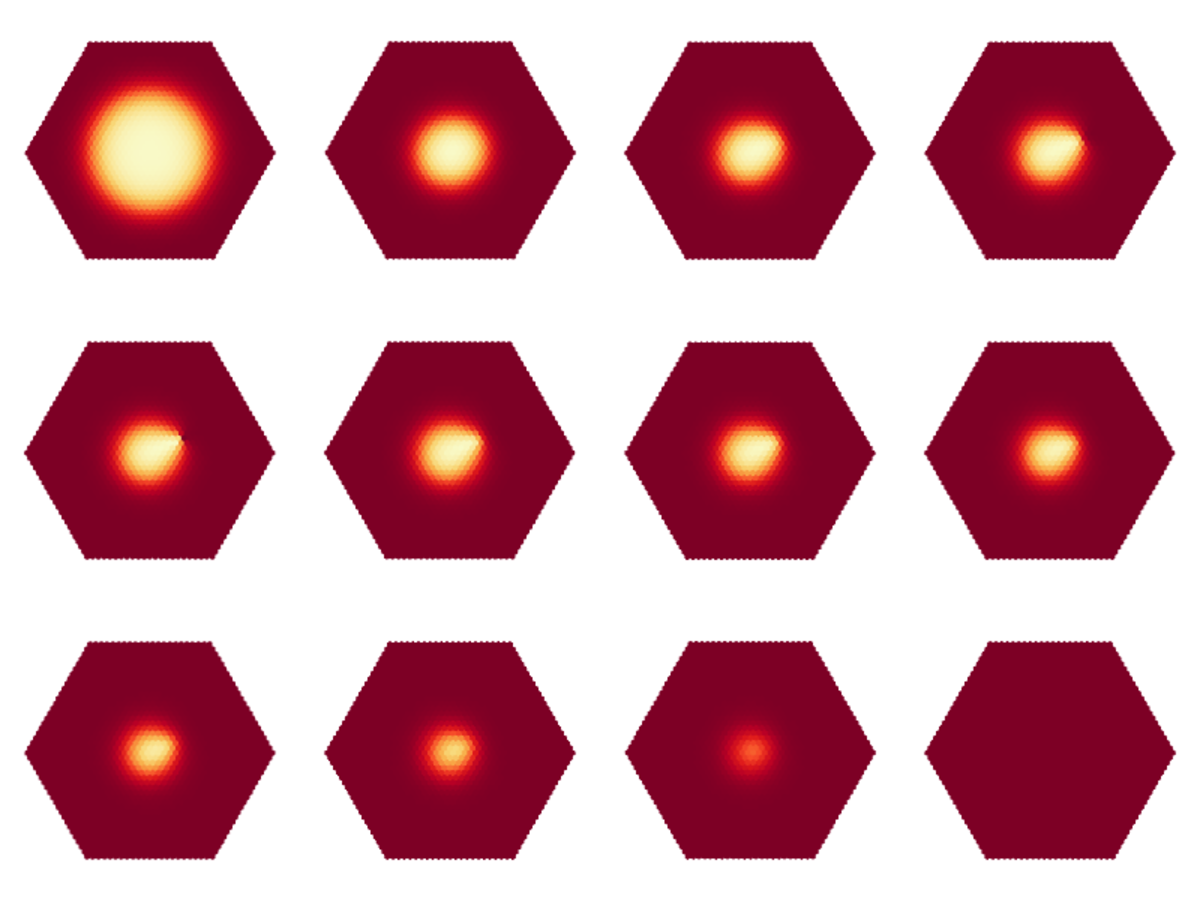

In [195]:
Image(os.path.join('png', last_GNEBM_state_pinbs(6, 600), 'grid.png'), width=500)

# Comparison

We can combine the results of the two systems with different boundary conditions:

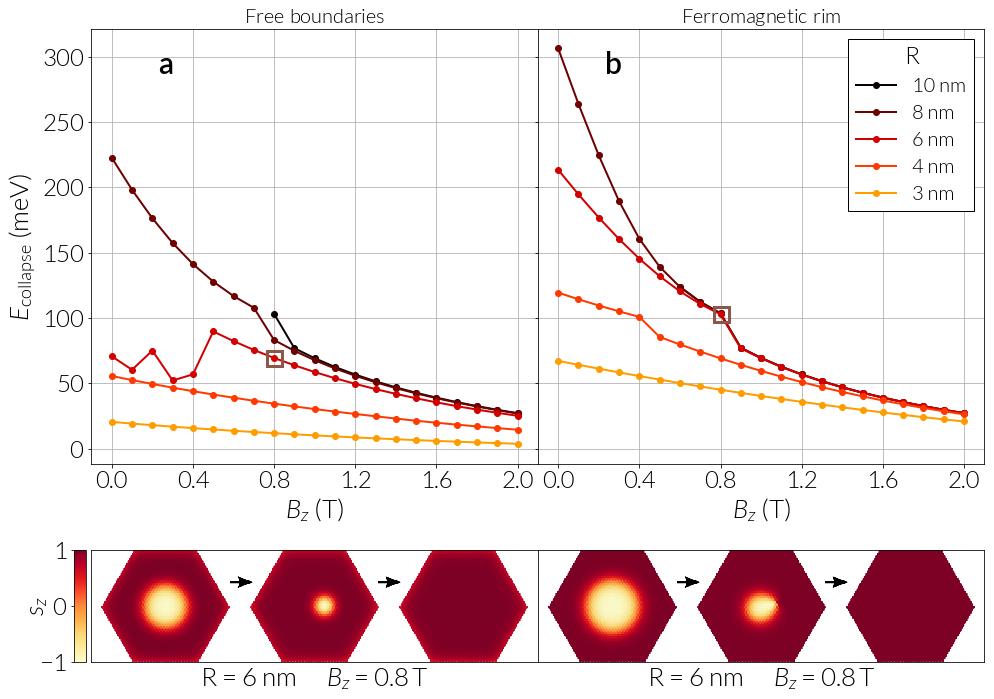

In [204]:
B_range = np.arange(0, 2001, 100)

cm_subsection = np.linspace(0.4, 1, len(R_range)) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection][-1::-1]

f = plt.figure(figsize=(16, 8))

ax1 = f.add_subplot(121)
for i, R in enumerate(R_range):
    if R == 10:
        fields_range = slice(8, None)
    else:
        fields_range = slice(0, None)
        
    ax1.plot(B_range[fields_range] * 1e-3, energy_barriers_map[R][fields_range], 'o-', 
             color=cm_colors[i], label='{} nm'.format(R))
    
         
    
ax2 = f.add_subplot(122, sharey=ax1)    
for i, R in enumerate(R_range):
    if R == 10:
        fields_range = slice(6, None)
    else:
        fields_range = slice(0, None)
    ax2.plot(B_range[fields_range] * 1e-3, energy_barriers_map_pinbs[R][fields_range], 'o-', 
             color=cm_colors[i], label='{} nm'.format(R))


ax1.set_title(r'$\mathrm{Free}\,\,\mathrm{boundaries}$', fontsize=20)    
ax1.set_xticks(B_range[::4] * 1e-3)
ax1.set_xticklabels(B_range[::4] * 1e-3)
ax1.set_ylabel(r'$E_{\mathrm{collapse}}$ (meV)')
ax1.set_xlabel(r'$B_{z}$ (T)')
ax1.grid()
ax1.text(0.15, 0.95, 'a' , horizontalalignment='left', verticalalignment='top',
         transform=ax1.transAxes, fontweight='bold', fontsize=30)

ax2.set_title(r'$\mathrm{Ferromagnetic}\,\,\mathrm{rim}$', fontsize=20)
ax2.set_xticks(B_range[::4] * 1e-3)
ax2.set_xticklabels(B_range[::4] * 1e-3)
ax2.legend(title='R', loc=1)
ax2.set_xlabel(r'$B_{z}$ (T)')
ax2.grid()
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.text(0.15, 0.95, 'b' , horizontalalignment='left', verticalalignment='top',
         transform=ax2.transAxes, fontweight='bold', fontsize=30)

plt.subplots_adjust(wspace=0)

# -----------------------------------------------------------------------------

box = ax1.get_position()
axIm1 = plt.axes([box.x0, -0.25, box.width, box.height - 0.5])
axIm1.set_xticks([])
axIm1.set_yticks([])
axIm1.imshow(plt.imread('inkscape/sk_fm_collapse_transition/transition.png'))
axIm1.set_xlabel(r'R = 6 nm      $B_{z}=0.8\,\mathrm{T}$')
ax1.plot(0.8, energy_barriers_map[6][8], 's',
         color='C5', markerfacecolor='None', ms=15, mew=3
         )

box = ax2.get_position()
axIm2 = plt.axes([box.x0, -0.25, box.width, box.height - 0.5])
axIm2.set_xticks([])
axIm2.set_yticks([])
axIm2.imshow(plt.imread('inkscape/sk_fm_collapse_transition/transition_PBS.png'))
axIm2.set_xlabel(r'R = 6 nm      $B_{z}=0.8\,\mathrm{T}$')
ax2.plot(0.8, energy_barriers_map_pinbs[6][8], 's',
         color='C5', markerfacecolor='None', ms=15, mew=3
         )

# Draw a colorbar
box = axIm1.get_position()
axCb = plt.axes([box.x0 - 0.015, -0.22, 0.01, 0.195])
cb = matplotlib.colorbar.ColorbarBase(axCb, plt.cm.YlOrRd, orientation="vertical",
                                      ticks=[-1, 0, 1], 
                                      norm=matplotlib.colors.Normalize(vmin=-1, vmax=1))
cb.set_label(r'$s_{z}$', rotation=90, y=.5, labelpad=-60)
axCb.yaxis.set_ticks_position('left')

# -----------------------------------------------------------------------------


plt.savefig('hexagons_nebm_R_B_skyrmion-collapse-energy-barrier_FreeBS-FMRim.pdf', 
            bbox_inches='tight')